# Plant Disease Detection 

## Imports

In [189]:
import torch
from torch import nn
from torch.utils.data import DataLoader
print(torch.__version__)

import torchvision
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights
from torchvision.datasets import ImageFolder
from torchvision import transforms
print(torchvision.__version__)

from typing import OrderedDict

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


import torchmetrics

from torchinfo import summary

2.6.0.dev20241206+cu126
0.20.0.dev20241206+cu126


In [133]:
device='cuda' if torch.cuda.is_available()  else "cpu"
device

'cuda'

## Data Acquisition

In [134]:
IMAGESIZE=256
CHANNELS=3

BATCHSIZE=32


In [135]:
transform_image=transforms.Compose([
    transforms.Resize((IMAGESIZE,IMAGESIZE)),
    transforms.ToTensor()
])

In [136]:
torch.manual_seed(42)
Train_Data_iterator=ImageFolder(root='./data/train', transform=transform_image )
Test_Data_iterator=ImageFolder(root='./data/test', transform=transform_image )
Train_Data_loader=DataLoader(Train_Data_iterator,batch_size=BATCHSIZE,shuffle=True)
Test_Data_loader=DataLoader(Test_Data_iterator,batch_size=BATCHSIZE,shuffle=True)

In [138]:
Train_Data_iterator,Test_Data_iterator

(Dataset ImageFolder
     Number of datapoints: 22068
     Root location: ./data/train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 5516
     Root location: ./data/test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [139]:
classes=list(Train_Data_iterator.classes)
# accuracy_fn = Accuracy(task="multiclass",num_classes=len(classes)).to(device)
# accuracy_fn

In [194]:
classes

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy']

In [140]:
print("classes :",*classes,sep="\n\t")

classes :
	Apple___Apple_scab
	Apple___Black_rot
	Apple___Cedar_apple_rust
	Apple___healthy
	Cherry_(including_sour)___Powdery_mildew
	Cherry_(including_sour)___healthy
	Grape___Black_rot
	Grape___Esca_(Black_Measles)
	Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
	Grape___healthy
	Peach___Bacterial_spot
	Peach___healthy


## Data Visualization

Text(0.5, 1.0, 'Apple___Apple_scab')

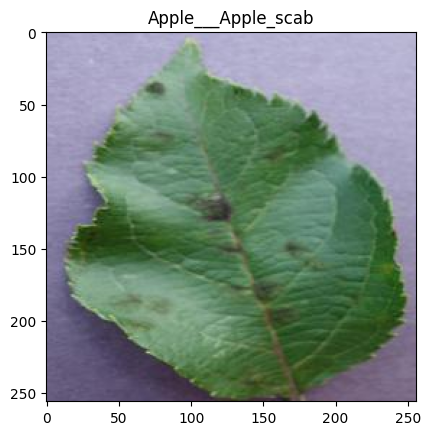

In [141]:
# torch.manual_seed(42)
# rand_idx=0
rand_idx=torch.randint(0,len(Train_Data_iterator),[1])
img,label=Train_Data_iterator[rand_idx]
plt.imshow(img.squeeze().permute(1,2,0))
plt.title(classes[label])

In [142]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## Functions for Traininig and Testing

In [143]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               lossfn:torch.nn.Module,
               optimizer:torch.optim,
               accuracy_fn=accuracy_fn,
               device:torch.device=device):
    #training 
    train_acc,train_loss=0,0
    for batch,(x,y) in tqdm(enumerate(dataloader)):
        # print(batch,x,torch.Tensor([y]).int())
        y = y.long()
        x,y=x.to(device),y.to(device)
        model.train()
        y_pred=model(x)
        # print(y_pred,y)
        loss=lossfn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_acc+=accuracy_fn(y,y_pred.argmax(dim=1))
        train_loss+=loss
        if(batch%400==0):
            pass
            # print(f"looked {batch*len(x)}/{len(dataloader.dataset)} samples.")
    train_loss/=len(dataloader)
    train_acc/=len(dataloader)
    print(f"training loss : {train_loss.item():.5f} train acc : {train_acc:.5f} ")
    return { 'model':model.__class__.__name__,
            'train_acc': train_acc,
            'train_loss':train_loss,
            'device':device
            }    
    

In [144]:
def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               lossfn:torch.nn.Module,
               accuracy_fn=accuracy_fn,
               device:torch.device=device):
    "testing loop on test data"
    test_loss,test_acc=0,0
    model.eval()
    with torch.inference_mode():
        for x,y in dataloader:
            y=y.long()
            x,y=x.to(device),y.to(device)
            test_pred=model(x)
            test_loss+=lossfn(test_pred,y)
            test_acc+=accuracy_fn(y,test_pred.argmax(dim=1))
        test_loss/=len(dataloader)
        test_acc/=len(dataloader)
    print(f"test loss : {test_loss.item():.5f} test acc : {test_acc:.5f}")
    return {'model':model.__class__.__name__,
            'model_loss':test_loss.item(),
            'model_acc':test_acc
            }        

In [145]:
model1 = efficientnet_b1(weights=EfficientNet_B1_Weights.DEFAULT)

In [146]:
for param in model1.features.parameters():
    param.requires_grad = False

In [147]:
model1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(classes), bias=True)
)

In [148]:
summary(model1,input_size=(1, 3,256,256),col_names=["input_size", "output_size", "num_params","trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 256, 256]          [1, 12]                   --                        Partial
├─Sequential: 1-1                                       [1, 3, 256, 256]          [1, 1280, 8, 8]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 256, 256]          [1, 32, 128, 128]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 256, 256]          [1, 32, 128, 128]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 128, 128]         [1, 32, 128, 128]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 128, 128]         [1, 32, 128, 128]         --                        --
│    └─Sequential

In [149]:
model1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=12, bias=True)
)

In [150]:
torch.manual_seed(42)
lossfn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model1.parameters(),lr=0.05)

model1.to(device)
epochs=4
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch} --------------------------------------------------------\n\n")
    train_step(model1,Train_Data_loader,lossfn,optimizer,accuracy_fn,device)
    print("evaluation start\n\n")
    test_step(model1,Test_Data_loader,lossfn,accuracy_fn,device)


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0 --------------------------------------------------------




0it [00:00, ?it/s]

training loss : 0.50162 train acc : 91.28442 
evaluation start


test loss : 0.17512 test acc : 97.23627
Epoch 1 --------------------------------------------------------




0it [00:00, ?it/s]

training loss : 0.34774 train acc : 95.32156 
evaluation start


test loss : 0.09598 test acc : 98.57298
Epoch 2 --------------------------------------------------------




0it [00:00, ?it/s]

training loss : 0.37343 train acc : 95.86413 
evaluation start


test loss : 0.08936 test acc : 98.82587
Epoch 3 --------------------------------------------------------




0it [00:00, ?it/s]

training loss : 0.40477 train acc : 96.29257 
evaluation start


test loss : 0.06021 test acc : 99.18714


In [156]:
#Saving the model
torch.save(model1.state_dict(),"model.pth")

## Custom modelling

In [77]:
class DiseaseModel(nn.Module):
    def __init__(self,model,num_classes):
        super().__init__()
        self.model = model
        self.classifier = nn.Sequential( 
                          nn.Dropout(p=0.2, inplace=True),
                          nn.Linear(in_features=1280, out_features=num_classes, bias=True)
                        ) 
        self.pretrained()
        
    def pretrained(self):
        for param in self.model.features.parameters():
            param.requires_grad = False
        self.model.classifier = self.classifier 
        
    def forward(self,x):
        return self.model(x)       

In [78]:
model3 = DiseaseModel(efficientnet_b1(weights=None),len(classes))

In [ ]:
# model1.state_dict()

OrderedDict([('features.0.0.weight',
              tensor([[[[ 3.5637e-01, -3.9536e+00,  6.0697e-01],
                        [ 3.4295e-01,  2.7644e+00,  4.3559e-01],
                        [-1.8645e-01, -8.7859e-02, -3.2967e-01]],
              
                       [[ 1.4457e-01, -6.9390e+00,  6.4530e-01],
                        [ 1.0947e+00,  5.1789e+00,  1.1849e+00],
                        [-4.2976e-01, -9.3647e-02, -7.8200e-01]],
              
                       [[ 4.1802e-01, -2.3925e+00,  4.0734e-01],
                        [ 1.5750e-01,  1.8682e+00,  1.6627e-01],
                        [-1.8791e-01, -1.1416e-01, -3.1263e-01]]],
              
              
                      [[[-5.4691e-01, -1.6249e-01, -7.9661e-01],
                        [-3.8267e-01, -1.6604e-01, -3.9609e-01],
                        [-6.3246e-01, -6.6785e-01,  2.8481e-01]],
              
                       [[-4.5147e-01, -9.2430e-02, -8.2167e-01],
                        [-1.4177e-01, 

In [106]:
model1.state_dict().keys(),model3.state_dict().keys()

(odict_keys(['features.0.0.weight', 'features.0.1.weight', 'features.0.1.bias', 'features.0.1.running_mean', 'features.0.1.running_var', 'features.0.1.num_batches_tracked', 'features.1.0.block.0.0.weight', 'features.1.0.block.0.1.weight', 'features.1.0.block.0.1.bias', 'features.1.0.block.0.1.running_mean', 'features.1.0.block.0.1.running_var', 'features.1.0.block.0.1.num_batches_tracked', 'features.1.0.block.1.fc1.weight', 'features.1.0.block.1.fc1.bias', 'features.1.0.block.1.fc2.weight', 'features.1.0.block.1.fc2.bias', 'features.1.0.block.2.0.weight', 'features.1.0.block.2.1.weight', 'features.1.0.block.2.1.bias', 'features.1.0.block.2.1.running_mean', 'features.1.0.block.2.1.running_var', 'features.1.0.block.2.1.num_batches_tracked', 'features.1.1.block.0.0.weight', 'features.1.1.block.0.1.weight', 'features.1.1.block.0.1.bias', 'features.1.1.block.0.1.running_mean', 'features.1.1.block.0.1.running_var', 'features.1.1.block.0.1.num_batches_tracked', 'features.1.1.block.1.fc1.weigh

In [108]:
## Arranging the keys to be same for the model of efficientnet and custom model.

state_dict = model3.state_dict()
new_state_dict = OrderedDict()

for k, v in state_dict.items():

    if k[:6] == 'model.':
        name = k[6:]  # remove `model.`
    else:
        name = k
    state_dict[k]=model1.state_dict()[name]

In [109]:
model3.load_state_dict(state_dict)

<All keys matched successfully>

In [127]:
model3.state_dict().keys()

odict_keys(['model.features.0.0.weight', 'model.features.0.1.weight', 'model.features.0.1.bias', 'model.features.0.1.running_mean', 'model.features.0.1.running_var', 'model.features.0.1.num_batches_tracked', 'model.features.1.0.block.0.0.weight', 'model.features.1.0.block.0.1.weight', 'model.features.1.0.block.0.1.bias', 'model.features.1.0.block.0.1.running_mean', 'model.features.1.0.block.0.1.running_var', 'model.features.1.0.block.0.1.num_batches_tracked', 'model.features.1.0.block.1.fc1.weight', 'model.features.1.0.block.1.fc1.bias', 'model.features.1.0.block.1.fc2.weight', 'model.features.1.0.block.1.fc2.bias', 'model.features.1.0.block.2.0.weight', 'model.features.1.0.block.2.1.weight', 'model.features.1.0.block.2.1.bias', 'model.features.1.0.block.2.1.running_mean', 'model.features.1.0.block.2.1.running_var', 'model.features.1.0.block.2.1.num_batches_tracked', 'model.features.1.1.block.0.0.weight', 'model.features.1.1.block.0.1.weight', 'model.features.1.1.block.0.1.bias', 'mode

## Saving and Loading the model

In [128]:
torch.save(model3.state_dict(),"custom_model.pth")

In [130]:
model4=DiseaseModel(efficientnet_b1(weights=None),len(classes))
model4.load_state_dict(torch.load("custom_model.pth"))

<All keys matched successfully>

In [131]:
test_step(model4.to(device),Test_Data_loader,lossfn,accuracy_fn,device)

test loss : 0.10154 test acc : 98.78974


{'model': 'DiseaseModel',
 'model_loss': 0.10153741389513016,
 'model_acc': 98.78973988439306}

In [ ]:
def predict_img():
    model_load=model4=DiseaseModel(efficientnet_b1(weights=None),len(classes))
model4.load_state_dict(torch.load("custom_model.pth"))

## Evaluation of the Model

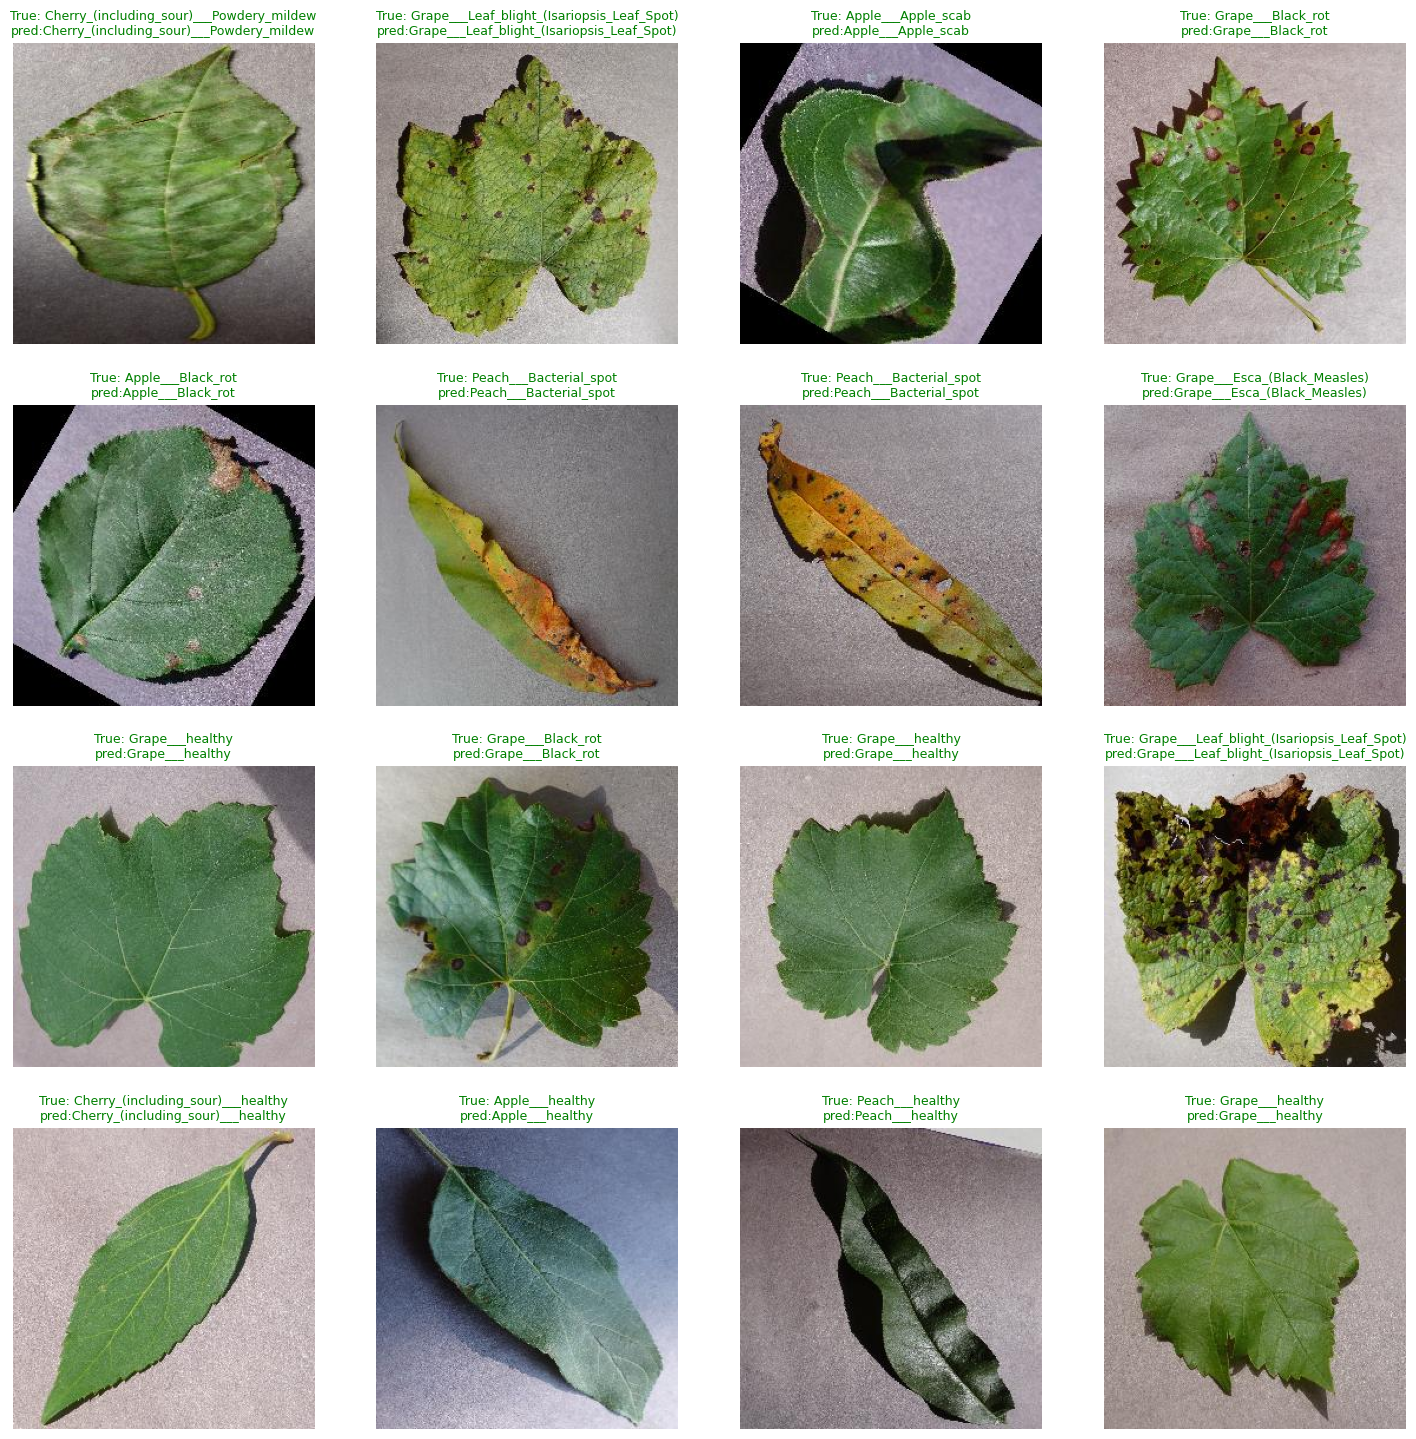

In [163]:
plt.figure(figsize=(18,18))
nrows=4
ncols=4
for i in range(nrows*ncols):
    plt.subplot(nrows,ncols,i+1)
    rand_idx=torch.randint(0,len(Test_Data_iterator),[1])
    img,label=Test_Data_iterator[rand_idx]
    y_pred=model1(img.unsqueeze(dim=0).to(device)).argmax(dim=1)
    pred_label=classes[y_pred]
    plt.imshow(img.squeeze().permute(1,2,0))
    c='r'
    if label==y_pred:
        c='g'
    plt.title(f"True: {classes[label]}\npred:{pred_label}",c=c,fontsize=9)
    plt.axis(False)

## Classification Metrics

In [184]:
from tqdm.auto import tqdm
y_pred=[]
y_true=[]
model1.eval()
with torch.inference_mode():
    for x,y in tqdm(Test_Data_loader,desc="making predictions........"):
        x,y=x.to(device),y.to(device)
        pred_logits=model1(x)
        pred_label=pred_logits.argmax(dim=1)
        y_pred.append(pred_label.cpu()) 
        y_true.append(y.cpu())
        
y_pred_tensor=torch.cat(y_pred)
y_true_tensor=torch.cat(y_true)

making predictions........:   0%|          | 0/173 [00:00<?, ?it/s]

In [185]:
y, pred_label

(tensor([ 0,  7,  1,  9,  2,  3,  7,  8,  5,  5, 11,  4], device='cuda:0'),
 tensor([ 0,  7,  1,  9,  2,  3,  7,  8,  5,  5, 11,  4], device='cuda:0'))

In [186]:
y_pred_tensor.numpy()

array([ 5,  1,  0, ...,  5, 11,  4], dtype=int64)

In [187]:
y_true_tensor.numpy()

array([ 5,  1,  0, ...,  5, 11,  4], dtype=int64)

[[488   5   1   6   3   0   0   0   0   0   1   0]
 [  1 493   1   2   0   0   0   0   0   0   0   0]
 [  0   0 440   0   0   0   0   0   0   0   0   0]
 [  0   1   0 496   0   2   0   0   0   0   2   1]
 [  0   0   1   0 420   0   0   0   0   0   0   0]
 [  0   1   0   0   0 455   0   0   0   0   0   0]
 [  0   0   0   0   0   0 469   3   0   0   0   0]
 [  0   0   0   0   0   0   6 474   0   0   0   0]
 [  0   0   0   0   0   0   0   0 430   0   0   0]
 [  0   0   0   0   0   0   0   0   0 423   0   0]
 [  0   0   0   0   1   0   0   0   0   0 458   0]
 [  0   0   0   0   0   0   0   0   0   0   7 425]]


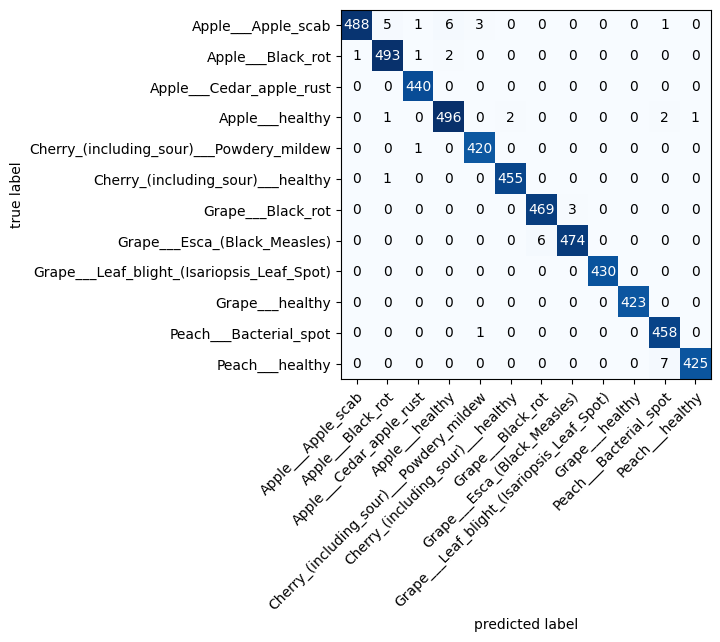

In [192]:
import mlxtend.plotting

metric=torchmetrics.ConfusionMatrix('multiclass',num_classes=len(classes))
res=metric(target=y_true_tensor,preds=y_pred_tensor).numpy()
mlxtend.plotting.plot_confusion_matrix(res,class_names=list(classes))
print(res)

In [193]:
from sklearn.metrics import classification_report
print(classification_report(y_true_tensor.numpy(), y_pred_tensor.numpy()))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       504
           1       0.99      0.99      0.99       497
           2       0.99      1.00      1.00       440
           3       0.98      0.99      0.99       502
           4       0.99      1.00      0.99       421
           5       1.00      1.00      1.00       456
           6       0.99      0.99      0.99       472
           7       0.99      0.99      0.99       480
           8       1.00      1.00      1.00       430
           9       1.00      1.00      1.00       423
          10       0.98      1.00      0.99       459
          11       1.00      0.98      0.99       432

    accuracy                           0.99      5516
   macro avg       0.99      0.99      0.99      5516
weighted avg       0.99      0.99      0.99      5516

